In [1]:
import matplotlib.pyplot as plt
from freegs.machine import Coil, Solenoid, Machine, Wall
from freegs.jtor import ConstrainBetapIp
from freegs.equilibrium import Equilibrium
from freegs.control import constrain
from freegs import solve
from Geometry import * 

In [2]:
# Global configurations

# Plasma Parameters
Ip = 10e3 # A
B0 = 0.10 # T
poloidal_plasma_beta = 0.05
xpoints = [(0.3, -0.24), (0.3, 0.24)]  # (R,Z) locations of X-points
isoflux = [(0.3, -0.24, 0.3, 0.24)] # (R1,Z1, R2,Z2) pairs

# Central Solenoid
cs_turns = 300 # Turns

# Dimension of coils
wc = 0.05
hc = 0.03

# Position of coils in (R, Z) pairs for coils located at (R, Z) and (R, -Z)
mirrored_PF_coils_positions = [
    (0.22, 0.3),
    (0.40, 0.27),
    (0.52, 0.15)
]

# Simulation Domain
Rmax = 0.7
Rmin = 0.01
Zmax = 0.6
Zmin = -0.6
n = 129           # Number of grid points (must always be in the form 2^m + 1)

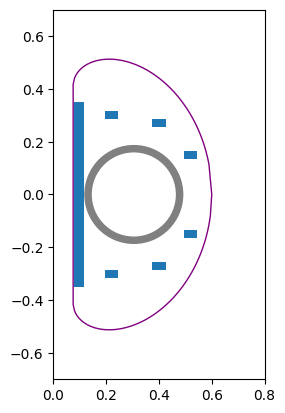

In [3]:
g = Geometry()

for index, (r, z) in enumerate(mirrored_PF_coils_positions):
    g.create_coil(f'PF{index}_U',r, z, wc, hc)
    g.create_coil(f'PF{index}_L',r, -z, wc, hc)

g.plot()

In [4]:
coils = [(name, Coil(prop['r0'], prop['z0'])) for name, prop in g.geom['coils'].items() if name != 'CS' ] 
coils += [('CS', Solenoid((g.cs_inner_radius + g.cs_outer_radius) / 2, -g.cs_height / 2, g.cs_height / 2, cs_turns))]

RWall, ZWall = list(zip(*g.geom['vv'][0])) 
walls = Wall(RWall, ZWall)

tokamak = Machine(coils, walls)
for coil_name, _ in tokamak.coils:
    if coil_name != 'CS':
        tokamak[coil_name].area = wc * hc
        
eq = Equilibrium(tokamak=tokamak,
                 Rmin=Rmin, Rmax=Rmax,  # Radial domain
                 Zmin=Zmin, Zmax=Zmax,  # Height range
                 nx=n, ny=n  # Number of grid points
                 )

profiles = ConstrainBetapIp(eq,
                            poloidal_plasma_beta,  # Plasma poloidal beta
                            Ip,  # Plasma current [Amps]
                            g.vv_major_radius * B0)  # Vacuum f=R*Bt

constraints = constrain(xpoints=xpoints, isoflux=isoflux)

In [5]:
solve(eq,
      profiles,
      constraints,
      check_limited=True,
      limit_it = 0,
      )

RuntimeError: Picard iteration failed to converge (too many iterations)

In [ ]:
# Print Results
print(
    'Plasma Properties:\n'
    f'\tPlasma Current       {eq.plasmaCurrent():8.2f}\n'
    f'\tPlasma Elongation    {eq.elongation():8.2f}\n'
    f'\tPlasma Triangularly  {eq.triangularity():8.2f}\n'
    f'\tPlasma Volume        {eq.plasmaVolume():8.2f}\n'
)

print('Current Profile')
for name, coil in eq.tokamak.coils:
    print(f'\t {name}: Current: {coil.current:8.2f} A')

print('')
print('Force on Coils')
for label, force in eq.getForces().items():
    if label != 'CS':
        print(
            f'Force on {label}:\n'
            f'\tF_R =   {force[0]:6.2f} N\n'
            f'\tF_Z =   {force[1]:6.2f} N'
        )